<a href="https://www.kaggle.com/code/ishmaelgarcia/assignment1?scriptVersionId=102952240" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-deaths/sample_submission.csv
/kaggle/input/covid-deaths/train.csv
/kaggle/input/covid-deaths/test.csv


# 1. Load CSV FILES

In [2]:
train_df = pd.read_csv('/kaggle/input/covid-deaths/train.csv')
print(train_df.shape)
test_df = pd.read_csv('/kaggle/input/covid-deaths/test.csv')
train_df.info()

(72864, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72864 entries, 0 to 72863
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              72864 non-null  int64  
 1   Data As Of                      72864 non-null  object 
 2   Start Date                      72864 non-null  object 
 3   End Date                        72864 non-null  object 
 4   Group                           72864 non-null  object 
 5   Year                            72864 non-null  object 
 6   Month                           13464 non-null  float64
 7   MMWR Week                       58608 non-null  float64
 8   Week-Ending Date                58608 non-null  object 
 9   HHS Region                      72864 non-null  object 
 10  Race and Hispanic Origin Group  72864 non-null  object 
 11  Age Group                       72864 non-null  object 
 12  COVID-19 Deaths     

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 2. Look and fix data

Now i'll look at head of training data then print null amounts for each column

In [3]:
train_df.head()


,id,Data As Of,Start Date,End Date,Group,Year,Month,MMWR Week,Week-Ending Date,HHS Region,Race and Hispanic Origin Group,Age Group,COVID-19 Deaths,Total Deaths,Footnote
0,0,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,0-4 years,0.0,104.0,NaN
1,1,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,5-17 years,0.0,41.0,NaN
2,2,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,18-29 years,0.0,190.0,NaN
3,3,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,30-39 years,0.0,237.0,NaN
4,4,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,40-49 years,0.0,325.0,NaN


In [4]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id                                    0
Data As Of                            0
Start Date                            0
End Date                              0
Group                                 0
Year                                  0
Month                             59400
MMWR Week                         14256
Week-Ending Date                  14256
HHS Region                            0
Race and Hispanic Origin Group        0
Age Group                             0
COVID-19 Deaths                   14926
Total Deaths                      24158
Footnote                          38371
dtype: int64
id                                   0
Data As Of                           0
Start Date                           0
End Date                             0
Group                                0
Year                                 0
Month                             1152
MMWR Week                            0
Week-Ending Date                     0
HHS Region                          

Here we see there is a clear pattern as Total Deaths increase so does Covid Deaths

I want to fill null info for Covid Deaths and Total Deaths columns 

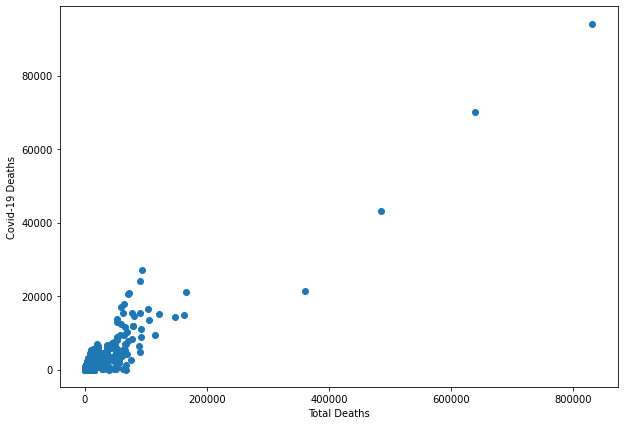

In [5]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(train_df['Total Deaths'], train_df['COVID-19 Deaths'])
ax.set_xlabel('Total Deaths')
ax.set_ylabel('Covid-19 Deaths')
plt.show()

Here we see during the colder months (week 1 being january to december being week 52) there is higher amount of covid deaths

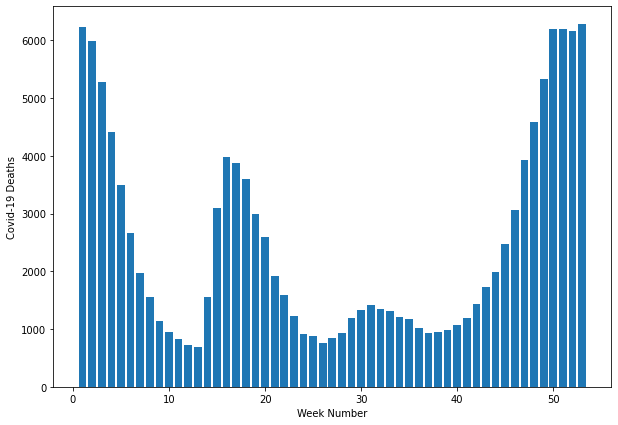

In [6]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(train_df['MMWR Week'], train_df['COVID-19 Deaths'])
ax.set_xlabel('Week Number')
ax.set_ylabel('Covid-19 Deaths')
plt.show()

There seems to be huge outliers when it comes to total and covid deats. below is a boxplot of total deaths

<AxesSubplot:xlabel='Total Deaths', ylabel='Year'>

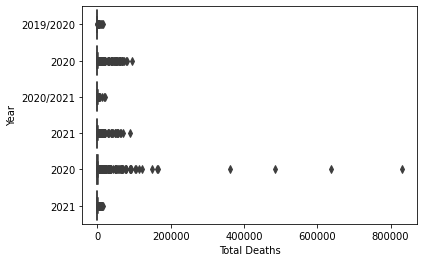

In [7]:
sns.boxplot(data = train_df, y = 'Year', x = 'Total Deaths')

Since our test data only has united states as a region we will drop region column. Then we can check covid deaths by race

['United States']


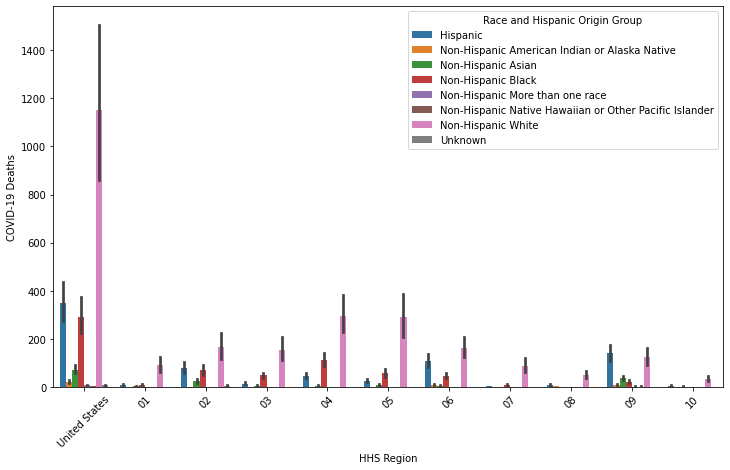

In [8]:
print(test_df['HHS Region'].unique())
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data = train_df, x = 'HHS Region', y = 'COVID-19 Deaths', hue = 'Race and Hispanic Origin Group')
plt.xticks(rotation=45)
plt.show()

So i'll grab all non nulls for each column and check the shape

Now  I will handle the outliers by grabbing the z-score of each column and dropping anything over a z-score of 3

This will help when I get a ratio of Covid Deaths to Total Deaths

In [9]:
import scipy.stats as stats

fixc = train_df['COVID-19 Deaths']
fixc = fixc.dropna()
fixt = train_df['Total Deaths']
fixt = fixt.dropna()
print(fixc.shape)

z_score1 = np.abs(stats.zscore(fixc))
fixc = fixc[(z_score1 < 3)]
z_score2 = np.abs(stats.zscore(fixt))
fixt = fixt[(z_score2 < 3)]
print(fixc.shape)

(57938,)
(57705,)


I grab the sum from all values in each column and make 2 different multipliers to fill null values of  Covid Deaths and Total Deaths

We go through the original DataFrame with the null values and outliers still in place and fix Covid Death column and Total Death column with the multiplier we found earlier

In [10]:
tdeathsum = fixt.sum()
cdeathsum = fixc.sum()
findt =  tdeathsum / cdeathsum
findc = cdeathsum / tdeathsum
print(findt)

9.946823384121686


In [11]:
train_df['COVID-19 Deaths'] = train_df.apply(lambda row: row['Total Deaths']*findc if np.isnan(row['COVID-19 Deaths']) else row['COVID-19 Deaths'], axis=1)
train_df['Total Deaths'] = train_df.apply(lambda row: row['COVID-19 Deaths']*findt if np.isnan(row['Total Deaths']) else row['Total Deaths'], axis=1)

Since I know the majority in the United States is Non-hispanic Whites I will fit my unknown races as such

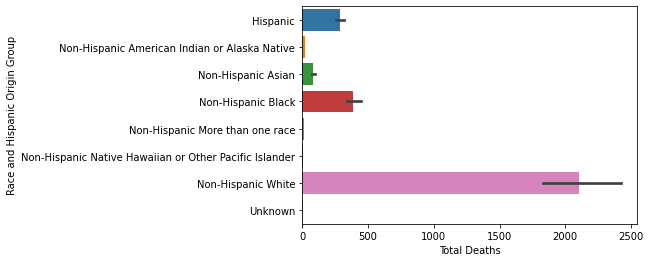

Hispanic                                                  9108
Non-Hispanic American Indian or Alaska Native             9108
Non-Hispanic Asian                                        9108
Non-Hispanic Black                                        9108
Non-Hispanic More than one race                           9108
Non-Hispanic Native Hawaiian or Other Pacific Islander    9108
Non-Hispanic White                                        9108
Unknown                                                   9108
Name: Race and Hispanic Origin Group, dtype: int64


In [12]:
sns.barplot(data = train_df, x = 'Total Deaths', y = 'Race and Hispanic Origin Group')
plt.show()
print(train_df['Race and Hispanic Origin Group'].value_counts())
train_df = train_df.replace(['Unknown'], 'Non-Hispanic White')
test_df = test_df.replace(['Unknown'], 'Non-Hispanic White')

Below I chose columns I did not think were predictors of Covid Deaths and dropped them

Then To fill MMWR Week column I grabbed the week number from the Start Date after converting Start Date to datetime format

After I will drop Start Date column from the DataFrame

To make sure my test data stays the same format as my train data I will do the same to my test DataFrame

In [13]:
#dropped id from test and train. need to grab test id from somewhere for submission
tr = test_df['id']

In [14]:
train_df.drop(['Footnote', 'Week-Ending Date','Month', 'Data As Of', 'Group','HHS Region','id', 'End Date'], axis = 1, inplace = True)
test_df.drop(['Month', 'Week-Ending Date', 'Data As Of', 'Group','HHS Region', 'id', 'End Date'], axis = 1, inplace = True)

In [15]:
train_df['Start Date'] = pd.to_datetime(train_df['Start Date'], format = '%m/%d/%Y')
train_df['Start Date'] = pd.to_datetime(train_df['Start Date'], format = '%m/%d/%Y')
train_df['MMWR Week'] = train_df.apply(lambda row: row['Start Date'].week if np.isnan(row['MMWR Week']) else row['MMWR Week'], axis=1)

Replace mixed years to the latter year

In [16]:
print(train_df['Year'].unique())

['2019/2020' '2020' '2020/2021' '2021' 2020 2021]


In [17]:
train_df = train_df.replace(['2019/2020'], '2020')
train_df = train_df.replace(['2020/2021'], '2021')

I will make a list of columns that are object types (categorical data)

And now we will check for null values to see what else we are missing

In [18]:
cat_columns = ['Start Date', 'Year', 'Race and Hispanic Origin Group', 'Age Group']
len(cat_columns)
print(train_df.isnull().sum())

Start Date                           0
Year                                 0
MMWR Week                            0
Race and Hispanic Origin Group       0
Age Group                            0
COVID-19 Deaths                   4591
Total Deaths                      4591
dtype: int64


Now I will drop the rows that I believe will hurt predictions. Since there are rows that is missing covid AND total deaths, they will be dropped

In [19]:
print(train_df.shape)
train_df = train_df.dropna()
print(train_df.isnull().sum())

(72864, 7)
Start Date                        0
Year                              0
MMWR Week                         0
Race and Hispanic Origin Group    0
Age Group                         0
COVID-19 Deaths                   0
Total Deaths                      0
dtype: int64


In [20]:
print(train_df.shape)
print(test_df.shape)

(68273, 7)
(1152, 6)


Now we will look at the shape of our test and train data to make sure they have the same shape besides the extra column in our train which is our Covid Deaths column

To make things easier and help make our data transformation consistent we concatenate our train and test data in one DataFrame

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68273 entries, 0 to 72863
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Start Date                      68273 non-null  datetime64[ns]
 1   Year                            68273 non-null  object        
 2   MMWR Week                       68273 non-null  float64       
 3   Race and Hispanic Origin Group  68273 non-null  object        
 4   Age Group                       68273 non-null  object        
 5   COVID-19 Deaths                 68273 non-null  float64       
 6   Total Deaths                    68273 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 4.2+ MB


In [22]:
print(train_df.shape)
print(test_df.shape)
final_df = pd.concat([train_df, test_df], axis = 0)

(68273, 7)
(1152, 6)


Now we will transform all object types using the category list we made earlier into numerical data with one hot encode using get_dummies

In case there are duplicate columns created we will drop them

Lets check how many columns we have now afterwards

In [23]:
final_df = pd.get_dummies(final_df, columns = cat_columns)
final_df = final_df.loc[:,~final_df.columns.duplicated()]
print(final_df.shape)


(69425, 126)


Now we can split train and test data up again

Since we know test data was concatenated at the end and values are 1152 we can just subtract that from our final_df rows amount we see above

In [24]:
new_train = final_df.iloc[:68273,:]
new_test = final_df.iloc[68273:,:]
print(new_test.shape)

(1152, 126)


Since we are predicting our test data we need to drop Covid Deaths column

In [25]:
new_test.drop(['COVID-19 Deaths'], axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We now set up our training data and testing data for a linear regression model

We will split our training data 80/20 

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = new_train['COVID-19 Deaths']
X = new_train.drop(columns = ['COVID-19 Deaths'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 39)

Lets fit our data to the model and check the score

In [27]:
linreg = LinearRegression()
linreg_s = linreg.fit(X_train, y_train)

print("R^2: {}".format(linreg.score(X_test, y_test)))
y_predlr = linreg.predict(X_test)

rmselr = np.sqrt(mean_squared_error(y_test, y_predlr))

print("Root Mean Squared Error: {}".format(rmselr))

R^2: 0.6832732070613169
Root Mean Squared Error: 243.86560996229545


             CVS
count  20.000000
mean    0.726366
std     0.145698
min     0.377559
25%     0.645174
50%     0.720210
75%     0.812407
max     0.982593


(array([1., 0., 1., 2., 3., 5., 2., 2., 1., 3.]),
 array([0.3775588 , 0.43806225, 0.4985657 , 0.55906915, 0.6195726 ,
        0.68007605, 0.7405795 , 0.80108295, 0.8615864 , 0.92208985,
        0.9825933 ]),
 <BarContainer object of 10 artists>)

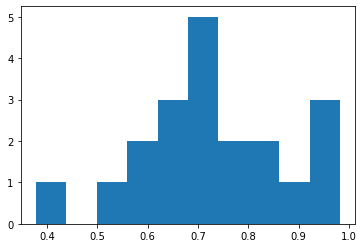

In [28]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linreg,X_train, y_train, cv = 20)
lin_scoresdf = pd.DataFrame(lin_scores, columns = ['CVS'])
print(lin_scoresdf.describe())
plt.hist(lin_scoresdf['CVS'])

Now we will do the same for Lasso, Ridge, and ElasticNet

In [29]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.4)
lasso_s = lasso.fit(X_train,y_train)
print(lasso_s.score(X_test, y_test))

print("R^2: {}".format(lasso.score(X_test, y_test)))
y_predl = lasso.predict(X_test)

rmsel = np.sqrt(mean_squared_error(y_test, y_predl))

print("Root Mean Squared Error: {}".format(rmsel))

0.6807744710885002
R^2: 0.6807744710885002
Root Mean Squared Error: 244.8256781719919


             CVS
count  20.000000
mean    0.724543
std     0.146582
min     0.375271
25%     0.642976
50%     0.718892
75%     0.809681
max     0.982708


(array([1., 0., 1., 2., 4., 4., 2., 2., 1., 3.]),
 array([0.37527123, 0.43601492, 0.49675862, 0.55750231, 0.618246  ,
        0.6789897 , 0.73973339, 0.80047708, 0.86122078, 0.92196447,
        0.98270816]),
 <BarContainer object of 10 artists>)

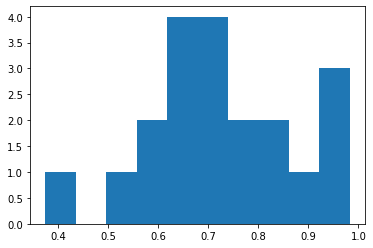

In [30]:
lass_scores = cross_val_score(lasso,X_train, y_train, cv = 20)
lass_scoresdf = pd.DataFrame(lass_scores, columns = ['CVS'])
print(lass_scoresdf.describe())
plt.hist(lass_scoresdf['CVS'])

In [31]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.4)
ridge_s = ridge.fit(X_train, y_train)
print(ridge_s.score(X_test, y_test))

print("R^2: {}".format(ridge.score(X_test, y_test)))
y_predr = ridge.predict(X_test)

rmser = np.sqrt(mean_squared_error(y_test, y_predr))

print("Root Mean Squared Error: {}".format(rmser))

0.6832986801038816
R^2: 0.6832986801038816
Root Mean Squared Error: 243.8558032075346


             CVS
count  20.000000
mean    0.726383
std     0.145679
min     0.377532
25%     0.645142
50%     0.720184
75%     0.812402
max     0.982598


(array([1., 0., 1., 2., 3., 5., 2., 2., 1., 3.]),
 array([0.37753194, 0.43803854, 0.49854515, 0.55905176, 0.61955836,
        0.68006497, 0.74057157, 0.80107818, 0.86158479, 0.92209139,
        0.982598  ]),
 <BarContainer object of 10 artists>)

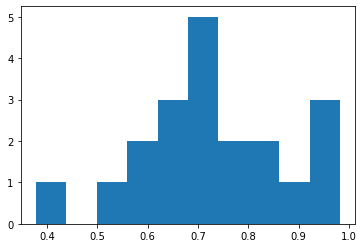

In [32]:
ridge_scores = cross_val_score(ridge,X_train, y_train, cv = 20)
ridge_scoresdf = pd.DataFrame(ridge_scores, columns = ['CVS'])
print(ridge_scoresdf.describe())
plt.hist(ridge_scoresdf['CVS'])

In [33]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 10)
ela_s = elastic_net.fit(X_train, y_train)
print(ela_s.score(X_test, y_test))

print("R^2: {}".format(elastic_net.score(X_test, y_test)))
y_preden = elastic_net.predict(X_test)

rmseen = np.sqrt(mean_squared_error(y_test, y_preden))

print("Root Mean Squared Error: {}".format(rmseen))

0.6761114328182665
R^2: 0.6761114328182665
Root Mean Squared Error: 246.6073223795828


             CVS
count  20.000000
mean    0.719719
std     0.148356
min     0.371631
25%     0.635239
50%     0.712588
75%     0.803219
max     0.982860


(array([1., 0., 1., 2., 4., 4., 3., 1., 1., 3.]),
 array([0.37163131, 0.43275417, 0.49387703, 0.5549999 , 0.61612276,
        0.67724562, 0.73836848, 0.79949135, 0.86061421, 0.92173707,
        0.98285993]),
 <BarContainer object of 10 artists>)

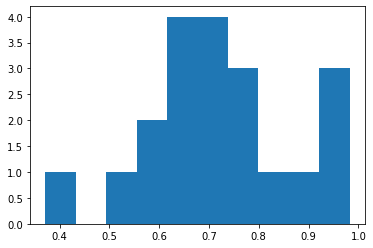

In [34]:
en_scores = cross_val_score(elastic_net,X_train, y_train, cv = 20)
en_scoresdf = pd.DataFrame(en_scores, columns = ['CVS'])
print(en_scoresdf.describe())
plt.hist(en_scoresdf['CVS'])

We see very close results but Ridge gives just a bit better score so we will use that to predict

In [35]:
y_pred = ridge.predict(new_test)

In [36]:
y_pred

array([ 14.20985358,  12.83750096,  30.33896862, ..., -13.22853999,
        -1.7848928 , -14.82207092])

Since we cant have negative deaths I will assign any negative prediction to 0

Now we make our submission file

In [37]:
submission = pd.DataFrame({'id':tr, 'COVID-19 Deaths':y_pred})
submission.loc[submission['COVID-19 Deaths'] < 0,'COVID-19 Deaths'] = 0
submission.to_csv('csv_to_submit5.csv', index = False)
print('saved file: ' + filename)

saved file: test.csv


In [38]:
print(submission.to_string())

        id  COVID-19 Deaths
0     5328        14.209854
1     5329        12.837501
2     5330        30.338969
3     5331        35.193356
4     5332        47.573018
5     5333       120.237351
6     5334       115.503462
7     5335       131.347562
8     5336       125.179384
9     5337         0.000000
10    5338         0.000000
11    5339         0.000000
12    5340         0.000000
13    5341         0.000000
14    5342         0.000000
15    5343         1.735151
16    5344        10.066283
17    5345         0.000000
18    5346         0.000000
19    5347         0.000000
20    5348         0.000000
21    5349         0.000000
22    5350         0.000000
23    5351         3.514454
24    5352        23.036720
25    5353        46.286460
26    5354        40.225609
27    5355         0.369215
28    5356         0.000000
29    5357        22.079392
30    5358        23.391952
31    5359        40.386723
32    5360       177.769909
33    5361       185.593410
34    5362       153